### Abrir archivo features


In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [203]:
df = pd.read_csv('./datasets/training_r21d_all_10_mean.csv')       # data training con el target
X_train = df.iloc[:,1:-2]
Y_train = df.iloc[:, -2]
# print(X_train)
# print(Y_train)

In [204]:
df = pd.read_csv('./datasets/val_r21d_complete_10.csv')       # data training con el target
X_val = df.iloc[:,1:-3]
Y_val = df.iloc[:, -3]
# print(X_val)
# print(Y_val)

In [205]:
df = pd.read_csv('./datasets/test_r21d_complete_10.csv')       # data training con el target
X_test = df.iloc[:,1:-1]
# print(X_test)

### Reducción de dimensionalidad


In [206]:
def graph_components(num_components, method, varianza_explicada):
    plt.figure(figsize=(10, 6))
    plt.bar(num_components, varianza_explicada, alpha=0.5, align='center', label='Varianza individual explicada')
    plt.step(num_components, np.cumsum(varianza_explicada), where='mid', label='Varianza acumulada')
    plt.ylabel('Porcentaje de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.title('Scree Plot de ' + method)
    plt.legend(loc='best')
    plt.axhline(y=95, color='r', linestyle='--')  # Línea opcional para el umbral de varianza deseado, ej. 95%
    plt.show()

#### PCA


data scaled
[[ 1.83620439 -0.91279091 -0.1195221  ... -0.66089667 -0.72470607
   0.90035303]
 [-0.30091796 -0.76995632  0.64169529 ... -0.3880678  -0.41626473
   0.26794282]
 [-0.46746561  1.81652137  0.0668968  ... -0.75397902 -0.26417388
  -0.57057412]
 ...
 [-1.31747121 -0.66253198 -0.56619558 ... -0.79620616  0.55276125
   0.58199193]
 [-0.12969289 -0.00435783 -0.64283866 ... -0.61261338 -0.5825971
   1.01780216]
 [ 0.27850179  0.04875291 -0.71099374 ...  0.03093929 -0.53175494
  -0.06855909]]
max 11.948867782324974
min -2.0542499510158576


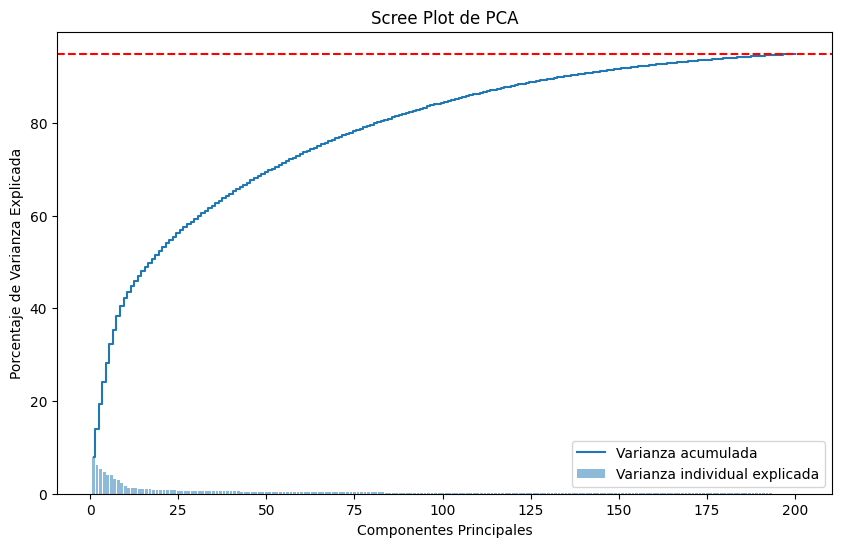

In [207]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_train)

print("data scaled")
print(data_scaled)
print("max", np.max(data_scaled))
print("min", np.min(data_scaled))

X_train_scaled = data_scaled

# Define the parameter grid

# Ajustar el PCA
pca = PCA(n_components=200)
pca.fit(X_train_scaled)


# Porcentaje de varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_ * 100

# Número de componentes
num_componentes = np.arange(len(varianza_explicada)) + 1

#print(varianza_explicada)
#print(num_components)
#print(pca.explained_variance_ratio_.sum())
#print(pca.singular_values_)

graph_components(num_componentes, "PCA", varianza_explicada)


In [208]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1

print(f'Optimal number of components: {optimal_components}')

Optimal number of components: 135


In [209]:
pca = PCA(n_components=140)
pca.fit(X_train_scaled)

# Transformar los datos al nuevo espacio
features_transformed = pca.transform(X_train_scaled)      # features_transformed es un numpy array
X_train_pca = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Transformar los datos al nuevo espacio
features_transformed = pca.transform(X_test_scaled)      # features_transformed es un numpy array
X_test_pca = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)

# Transformar los datos al nuevo espacio
features_transformed = pca.transform(X_val_scaled)      # features_transformed es un numpy array
X_val_pca = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

#### Truncated SVD

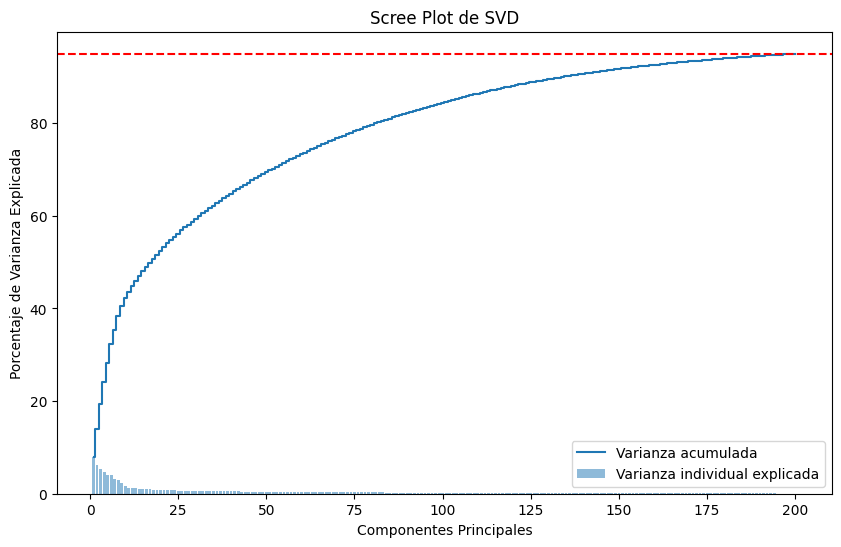

In [210]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, n_iter=5, random_state=42) #cambiar numero de componentes
svd.fit(X_train_scaled)

# Porcentaje de varianza explicada por cada componente
varianza_explicada = svd.explained_variance_ratio_ * 100

# Número de componentes
num_components = np.arange(len(varianza_explicada)) + 1

#print(varianza_explicada)
#print(num_components)
#print(svd.explained_variance_ratio_.sum())
#print(svd.singular_values_)

graph_components(num_components, "SVD", varianza_explicada)

In [211]:
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1

print(f'Optimal number of components: {optimal_components}')

Optimal number of components: 135


In [212]:
svd = TruncatedSVD(n_components=135, n_iter=5, random_state=42) #cambiar numero de componentes
svd.fit(X_train_scaled)

# Transformar los datos al nuevo espacio
features_transformed = svd.transform(X_train_scaled)      # features_transformed es un numpy array
X_train_svd = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

# Transformar los datos al nuevo espacio
features_transformed = svd.transform(X_test_scaled)      # features_transformed es un numpy array
X_test_svd = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)

# Transformar los datos al nuevo espacio
features_transformed = svd.transform(X_val_scaled)      # features_transformed es un numpy array
X_val_svd = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

#### LDA

(5424, 9)


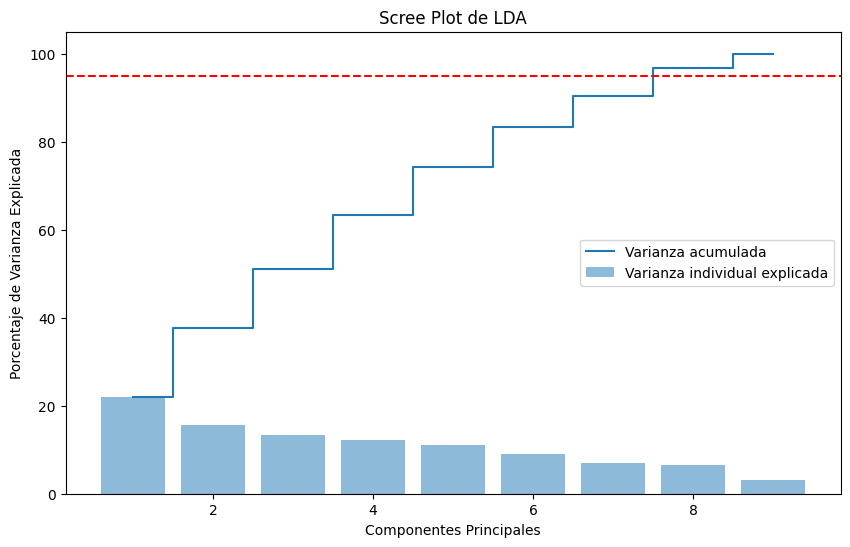

In [213]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, Y_train.to_numpy())
X_train_lda = pd.DataFrame(lda.transform(X_train.to_numpy()))
print(X_train_lda.shape)
varianza_explicada = lda.explained_variance_ratio_ * 100
num_componentes = np.arange(len(varianza_explicada)) + 1

graph_components(num_componentes, "LDA", varianza_explicada)

A diferencia de PCA y SVD, LDA es un algoritmo de reducción de dimensionalidad supervisado, le paso los labels. El número de componentes está limitado por *min(n_classes - 1, n_features)*

In [214]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, Y_train.to_numpy())

# Transformar los datos al nuevo espacio
features_transformed = lda.transform(X_train_scaled)      # features_transformed es un numpy array
X_train_lda = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

# Transformar los datos al nuevo espacio
features_transformed = lda.transform(X_test_scaled)      # features_transformed es un numpy array
X_test_lda = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

scaler = StandardScaler()
X_val_scaled = scaler.fit_transform(X_val)

# Transformar los datos al nuevo espacio
features_transformed = lda.transform(X_val_scaled)      # features_transformed es un numpy array
X_val_lda = pd.DataFrame(features_transformed)   # features_imputed es un DataFrame de pandas

#### UMAP

In [215]:
# !pip install umap-learn
# !pip install umap-learn[plot]
# !pip install dask[dataframe]

In [216]:
import umap
reducer = umap.UMAP()

reducer.fit(X_train_scaled)

X_train_umap = pd.DataFrame(reducer.transform(X_train_scaled))
X_val_umap = pd.DataFrame(reducer.transform(X_val_scaled))
X_test_umap = pd.DataFrame(reducer.transform(X_test_scaled))

<Axes: >

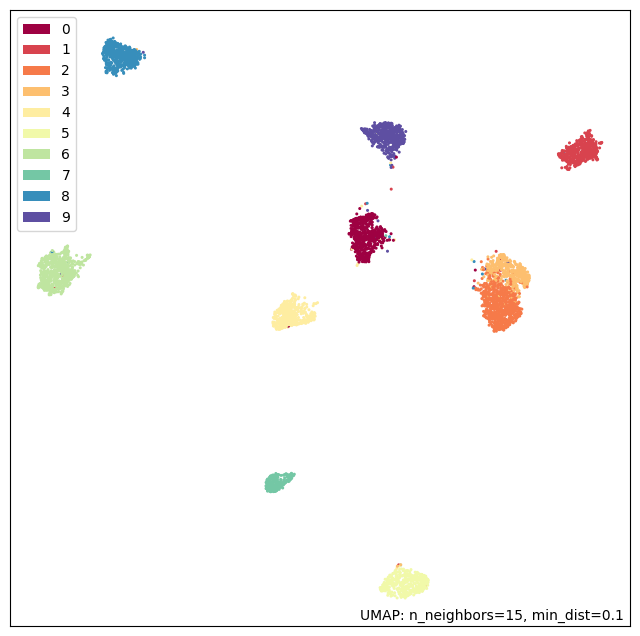

In [217]:
import umap.plot

reducer = umap.UMAP()

X_train_draw = reducer.fit(X_train_scaled)

umap.plot.points(X_train_draw, labels=Y_train_encoded)

<Axes: >

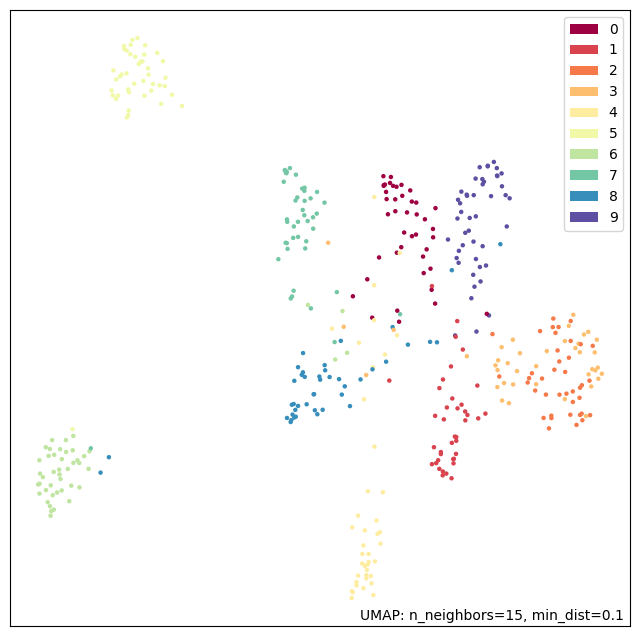

In [218]:
import umap.plot

reducer = umap.UMAP()

X_val_draw = reducer.fit(X_val_scaled)

umap.plot.points(X_val_draw, labels=Y_val_encoded)

In [219]:
print(X_train_umap.shape)
print(X_val_umap.shape)
print(X_test_umap.shape)

(5424, 2)
(422, 2)
(805, 2)


### Factor Analysis

In [220]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis
X, _ = load_digits(return_X_y=True)
transformer = FactorAnalysis(n_components=7, random_state=0)
X_fa = transformer.fit_transform(X)
X_fa.shape

(1797, 7)

### Accuracy testing

#### Kmeans

In [221]:
from sklearn.preprocessing import LabelEncoder
from kmeans import kmeans

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
# Calculates number of clusters so that it's equal to the number of labels 
n_clusters = len(np.unique(Y_train_encoded))
print(n_clusters)

10


In [222]:
X_train_pca_np = X_train_pca.to_numpy()
umbral = 0.3
centroides_km_pca, clusters_km_pca = kmeans(X_train_pca_np, n_clusters, umbral)

In [223]:
X_train_svd_np = X_train_svd.to_numpy()
umbral = 0.3
centroides_km_svd, clusters_km_svd = kmeans(X_train_svd_np, n_clusters, umbral)

In [224]:
X_train_lda_np = X_train_lda.to_numpy()
umbral = 0.3
centroides_km_lda, clusters_km_lda = kmeans(X_train_lda_np, n_clusters, umbral)

In [225]:
X_train_umap_np = X_train_umap.to_numpy()
umbral = 0.3
centroides_km_umap, clusters_km_umap = kmeans(X_train_umap_np, n_clusters, umbral)

#### DBSCAN

In [226]:
from dbscan import DBSCAN
radio = 1000
vecinos_min = 300

labels_db_pca = DBSCAN(X_train_pca_np, radio, vecinos_min)
labels_db_svd = DBSCAN(X_train_svd_np, radio, vecinos_min)
labels_db_lda = DBSCAN(X_train_lda_np, radio, vecinos_min)
labels_db_umap = DBSCAN(X_train_umap_np, radio, vecinos_min)

#### Resultados

In [227]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import mutual_info_score

In [228]:
ri_pc_km = rand_score(Y_train_encoded, clusters_km_pca)
ri_svd_km = rand_score(Y_train_encoded, clusters_km_svd)
ri_lda_km = rand_score(Y_train_encoded, clusters_km_lda)
ri_umap_km = rand_score(Y_train_encoded, clusters_km_umap)
print("El rand index de kmeans con pca es: ", ri_pc_km)
print("El rand index de kmeans con svd es: ", ri_svd_km)
print("El rand index de kmeans con lda es: ", ri_lda_km)
print("El rand index de kmeans con umap es: ", ri_umap_km)

#sc_pc_km = silhouette_score(Y_train_encoded, clusters_km_pca)
#sc_svd_km = silhouette_score(Y_train_encoded, clusters_km_svd)
#print("El silhouette coefficient de kmeans con pca es: ", sc_pc_km)
#print("El silhouette coefficient de kmeans con svd es: ", sc_svd_km)

mi_pc_km = mutual_info_score(Y_train_encoded, clusters_km_pca)
mi_svd_km = mutual_info_score(Y_train_encoded, clusters_km_svd)
mi_lda_km = mutual_info_score(Y_train_encoded, clusters_km_lda)
mi_umap_km = mutual_info_score(Y_train_encoded, clusters_km_umap)
print("El mutual information de kmeans con pca es: ", mi_pc_km)
print("El mutual information de kmeans con svd es: ", mi_svd_km)
print("El mutual information de kmeans con lda es: ", mi_lda_km)
print("El mutual information de kmeans con umap es: ", mi_umap_km)

El rand index de kmeans con pca es:  0.7833611292881788
El rand index de kmeans con svd es:  0.8020593484432361
El rand index de kmeans con lda es:  0.8328757335874678
El rand index de kmeans con umap es:  0.9176945322473873
El mutual information de kmeans con pca es:  0.21184470707042893
El mutual information de kmeans con svd es:  0.20741599837664768
El mutual information de kmeans con lda es:  1.0000084832844611
El mutual information de kmeans con umap es:  1.6602004365537522


In [229]:
labels_db_pca_np = np.array(labels_db_pca)
labels_db_svd_np = np.array(labels_db_svd)
labels_db_lda_np = np.array(labels_db_lda)
labels_db_umap_np = np.array(labels_db_umap)

ri_pc_db = rand_score(Y_train_encoded, labels_db_pca_np)
ri_svd_db = rand_score(Y_train_encoded, labels_db_svd_np)
ri_lda_db = rand_score(Y_train_encoded, labels_db_lda_np)
ri_umap_db = rand_score(Y_train_encoded, labels_db_umap_np)
print("El rand index de DBSCAN con pca es: ", ri_pc_db)
print("El rand index de DBSCAN con svd es: ", ri_svd_db)
print("El rand index de DBSCAN con lda es: ", ri_lda_db)
print("El rand index de DBSCAN con umap es: ", ri_umap_db)

Y_train_encoded_np = Y_train_encoded.reshape(-1, 1)

#sc_pc_db = silhouette_score(Y_train_encoded, labels_db_pca_np)
#sc_svd_db = silhouette_score(Y_train_encoded, labels_db_svd_np)
#print("El silhouette coefficient de DBSCAN con pca es: ", sc_pc_db)
#print("El silhouette coefficient de DBSCAN con svd es: ", sc_svd_db)

mi_pc_db = mutual_info_score(Y_train_encoded, labels_db_pca_np)
mi_svd_db = mutual_info_score(Y_train_encoded, labels_db_svd_np)
mi_lda_db = mutual_info_score(Y_train_encoded, labels_db_lda_np)
mi_umap_db = mutual_info_score(Y_train_encoded, labels_db_umap_np)

print("El mutual information de DBSCAN con pca es: ", mi_pc_db)
print("El mutual information de DBSCAN con svd es: ", mi_svd_db)
print("El mutual information de DBSCAN con lca es: ", mi_lda_db)
print("El mutual information de DBSCAN con umap es: ", mi_umap_db)

El rand index de DBSCAN con pca es:  0.10584948463253585
El rand index de DBSCAN con svd es:  0.10584948463253585
El rand index de DBSCAN con lda es:  0.10584948463253585
El rand index de DBSCAN con umap es:  0.10584948463253585
El mutual information de DBSCAN con pca es:  0.0
El mutual information de DBSCAN con svd es:  0.0
El mutual information de DBSCAN con lca es:  0.0
El mutual information de DBSCAN con umap es:  0.0


### Validation

In [230]:
label_encoder = LabelEncoder()
Y_val_encoded = label_encoder.fit_transform(Y_val)

X_val_lda_np = X_val_lda.to_numpy()
X_val_umap_np = X_val_umap.to_numpy()

umbral = 0.3
centroides_km_lda, clusters_km_lda = kmeans(X_val_lda_np, n_clusters, umbral)
centroides_km_umap, clusters_km_umap = kmeans(X_val_umap_np, n_clusters, umbral)

In [231]:
ri_lda_km = rand_score(Y_val_encoded, clusters_km_lda)
ri_umap_km = rand_score(Y_val_encoded, clusters_km_umap)
print("El rand index de kmeans con lda es: ", ri_lda_km)
print("El rand index de kmeans con umap es: ", ri_umap_km)

#sc_lda_km = silhouette_score(Y_val_encoded, clusters_km_lda)
#sc_umap_km = silhouette_score(Y_val_encoded, clusters_km_umap)
#print("El silhouette coefficient de kmeans con lda es: ", sc_lda_km)
#print("El silhouette coefficient de kmeans con umap es: ", sc_umap_km)

mi_lda_km = mutual_info_score(Y_val_encoded, clusters_km_lda)
mi_umap_km = mutual_info_score(Y_val_encoded, clusters_km_umap)
print("El mutual information de kmeans con lda es: ", mi_lda_km)
print("El mutual information de kmeans con umap es: ", mi_umap_km)

El rand index de kmeans con lda es:  0.8451666647904448
El rand index de kmeans con umap es:  0.8863122108273013
El mutual information de kmeans con lda es:  0.8093287747166702
El mutual information de kmeans con umap es:  1.3954848089830625


### Testing

In [232]:
X_test_lda_np = X_test_lda.to_numpy()
X_test_umap_np = X_test_umap.to_numpy()

umbral = 0.3
centroides_km_lda, clusters_km_lda = kmeans(X_test_lda_np, n_clusters, umbral)

centroides_km_umap, clusters_km_umap = kmeans(X_test_umap_np, n_clusters, umbral)

labels_db_lda = DBSCAN(X_test_lda_np, radio, vecinos_min)

labels_db_umap = DBSCAN(X_test_umap_np, radio, vecinos_min)

<Axes: >

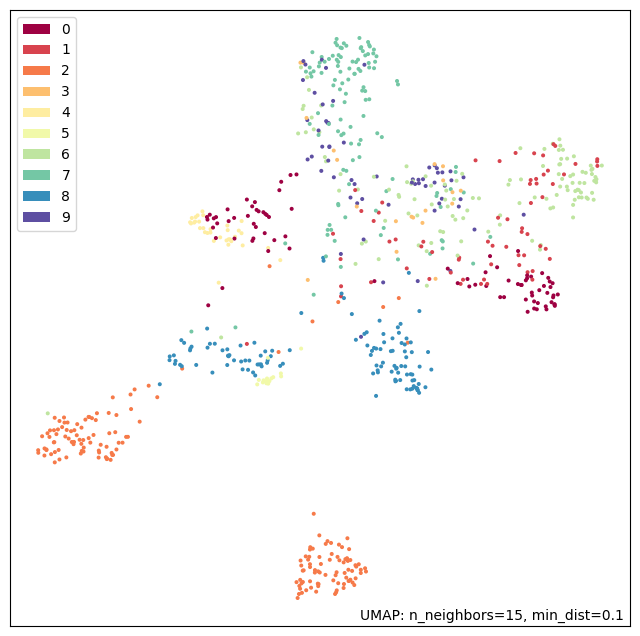

In [233]:
import umap.plot

reducer = umap.UMAP()

X_test_draw = reducer.fit(X_test_scaled)

umap.plot.points(X_test_draw, labels=clusters_km_umap)

In [234]:
print(type(clusters_km_umap))
df = pd.read_csv('./datasets/test_r21d_complete_10.csv')       # data training con el target
Y_test = df.iloc[:,-1:].copy()
print(Y_test)

<class 'numpy.ndarray'>
      youtube_id
0    zujZagp-4jQ
1    ZuvChCAjbak
2    ZxpwgIZg4lI
3    zz1YMml9Z6k
4    08JqXh8jCgk
..           ...
800  zMdAi3xo7Us
801  ZmNQ6kMVb-g
802  ZOZslTEUt7M
803  zrrqDli62kE
804  ZTTEkAxEnUs

[805 rows x 1 columns]


In [235]:
# guardar en csv el test

Y_test.loc[:, "label"] = clusters_km_lda
Y_test = Y_test.set_index("youtube_id")

Y_test.to_csv("results/y_test_km_lda_" + str(umbral) + ".csv")

Y_test.loc[:, "label"] = clusters_km_umap

Y_test.to_csv("results/y_test_km_umap_" + str(umbral) + ".csv")

Y_test.loc[:, "label"] = labels_db_lda

#Y_test.to_csv("results/y_test_db_lda_" + str(radio) + "_" + str(vecinos_min) + ".csv")

Y_test.loc[:, "label"] = labels_db_umap

#Y_test.to_csv("results/y_test_db_umap_" + str(radio) +"_+ str(vecinos_min + ".csv")

             label
youtube_id        
zujZagp-4jQ      0
ZuvChCAjbak      8
ZxpwgIZg4lI      4
zz1YMml9Z6k      5
08JqXh8jCgk      5
...            ...
zMdAi3xo7Us      0
ZmNQ6kMVb-g      5
ZOZslTEUt7M      0
zrrqDli62kE      8
ZTTEkAxEnUs      7

[805 rows x 1 columns]
